# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
num_classes = 10      # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784    # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256      # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100    # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128      # кількість нейронів 1-го шару
n_hidden_2 = 256      # кількість нейронів 2-го шару

In [3]:
dropout_prob = 0.5    # ймовірність вимкнення нейрона при dropout

In [4]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# # Створимо нейронну мережу

# class DenseLayer(tf.Module):
#     def __init__(self, in_features, out_features, name=None):
#         super().__init__(name=name)
#         self.w = tf.Variable(
#             tf.random.normal([in_features, out_features]), name="w"
#         )
#         self.b = tf.Variable(tf.zeros([out_features]), name="b")

#     def __call__(self, x, activation=0):
#         y = tf.matmul(x, self.w) + self.b
#         if activation != 0:
#             return tf.nn.softmax(y)
#         else:
#             return tf.nn.sigmoid(y)

# class NN(tf.Module):
#   def __init__(self, name=None):
#     super().__init__(name=name)

#     # Перший шар, який складається з 128 нейронів
#     self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")

#     # Другий шар, який складається з 256 нейронів
#     self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")

#     # Вихідний шар
#     self.output = DenseLayer(n_hidden_2, num_classes, name="output")

#   def __call__(self, x):
#     # Передача даних через перші два шари та вихідний шар з функцією активації softmax
#     x = self.layer1(x)
#     x = self.layer2(x)
#     logits = self.output(x, activation=1)

#     return logits

v2

In [6]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class DropoutLayer(tf.Module):
    def __init__(self, dropout_prob):
        super().__init__()
        self.dropout_prob = dropout_prob

    def __call__(self, x):
        return tf.nn.dropout(x, rate=self.dropout_prob)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)

        self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
        self.dropout1 = DropoutLayer(dropout_prob)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
        self.dropout2 = DropoutLayer(dropout_prob)
        self.output = DenseLayer(n_hidden_2, num_classes, name="output")

    def __call__(self, x):
        x = self.layer1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.dropout2(x)
        logits = self.output(x, activation=1)

        return logits

Навчання мережі

In [7]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):

  """
  Функція для обчислення точності.

  Args:
    y_pred: Прогнози нейронної мережі.
    y_true: Справжні значення.

  Returns:
    Точність.
  """
  # Перетворення прогнозів у one-hot кодування
  y_pred = tf.argmax(y_pred, axis=1)
  # Обчислення точності
  return tf.reduce_mean(tf.cast(tf.equal(y_pred, y_true), tf.float32))

In [8]:
# # Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# # Функція навчання нейромережі
# def train(neural_net, input_x, output_y):
# #   # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
#   optimizer = tf.optimizers.SGD(learning_rate)

#   # Активація автоматичного диференціювання
#   with tf.GradientTape() as g:
#     pred = neural_net(input_x)
#     loss = cross_entropy(pred, output_y)

#     # Отримаємо список оптимізованих параметрів
#     gradients = g.gradient(loss, neural_net.trainable_variables)

#     # Обчислимо за ними значення градієнта
#     optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

#     # Модифікуємо параметри
# optimizer = tf.optimizers.SGD(learning_rate)

v2

In [9]:
# Оптимізатор
optimizer = tf.optimizers.Adam(learning_rate)
# optimizer = tf.optimizers.SGD(learning_rate)

# Як метрику якості використовуємо точність
def calculate_accuracy(y_pred, y_true):
  y_pred = tf.argmax(y_pred, axis=1)
  y_true = tf.cast(y_true, tf.int64)  # Convert y_true to int64
  return tf.reduce_mean(tf.cast(tf.equal(y_pred, y_true), tf.float32))

# Функція навчання нейромережі з dropout регуляризацією
def train_neural_net_with_dropout(neural_net, input_x, output_y):
  for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    with tf.GradientTape() as g:
      pred = neural_net(batch_x)
      loss = cross_entropy(pred, batch_y)

    gradients = g.gradient(loss, neural_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

    if step % display_step == 0:
      pred = neural_net(batch_x)
      acc = calculate_accuracy(pred, batch_y).numpy()  # Змінна batch_y не визначена
      print(f"Step: {step}, Loss: {loss.numpy()}, Accuracy: {acc}")

# Тренування нейронної мережі з dropout регуляризацією
# train_neural_net(neural_net, x_train, y_train)
train_neural_net_with_dropout(neural_net, x_train, y_train)

# Оцінка точності моделі на тестовій вибірці
test_predictions = neural_net(x_test)
test_accuracy = calculate_accuracy(test_predictions, y_test).numpy()
print(f"Accuracy on test set: {test_accuracy}")

Step: 100, Loss: 3273.4189453125, Accuracy: 0.17578125
Step: 200, Loss: 2890.807373046875, Accuracy: 0.171875
Step: 300, Loss: 2656.1943359375, Accuracy: 0.28515625
Step: 400, Loss: 2187.453369140625, Accuracy: 0.31640625
Step: 500, Loss: 1819.65380859375, Accuracy: 0.3984375
Step: 600, Loss: 1602.474609375, Accuracy: 0.3671875
Step: 700, Loss: 1405.155029296875, Accuracy: 0.4453125
Step: 800, Loss: 1187.673583984375, Accuracy: 0.4921875
Step: 900, Loss: 1006.8612670898438, Accuracy: 0.52734375
Step: 1000, Loss: 1192.21484375, Accuracy: 0.53515625
Step: 1100, Loss: 1050.744384765625, Accuracy: 0.55859375
Step: 1200, Loss: 847.7130126953125, Accuracy: 0.609375
Step: 1300, Loss: 769.7184448242188, Accuracy: 0.63671875
Step: 1400, Loss: 764.204345703125, Accuracy: 0.62890625
Step: 1500, Loss: 703.976806640625, Accuracy: 0.625
Step: 1600, Loss: 730.038330078125, Accuracy: 0.640625
Step: 1700, Loss: 729.2869873046875, Accuracy: 0.671875
Step: 1800, Loss: 745.1585693359375, Accuracy: 0.64453

Тренування мережі

In [10]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    with tf.GradientTape() as g:
      pred = neural_net(batch_x)
      loss = cross_entropy(pred, batch_y)

    gradients = g.gradient(loss, neural_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_history.append(loss.numpy())
        accuracy_history.append(calculate_accuracy(pred, tf.cast(batch_y, tf.int64)).numpy())

Виведення графіків

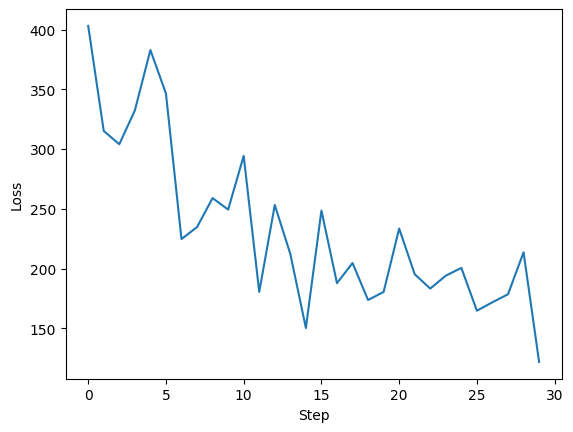

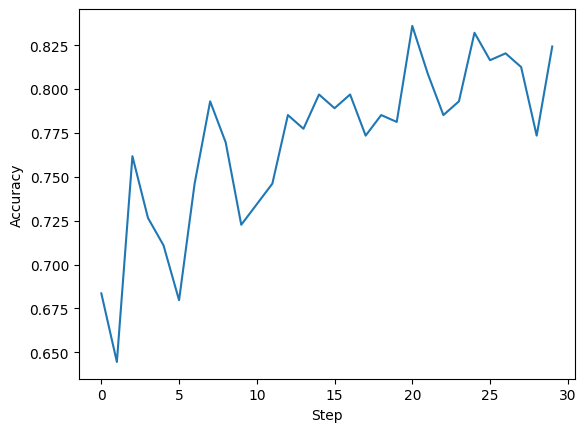

In [11]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

# Виведіть графік точності
plt.plot(range(len(accuracy_history)), accuracy_history)
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.show()


Прогноз та порівняння

In [13]:
# Проведення прогнозів на тестових даних
test_pred = neural_net(x_test)
test_pred_values = np.argmax(test_pred, axis=1)

# Порівняння з y_test та оцінка точності
test_accuracy = np.mean(test_pred_values == y_test)
print(f"Accuracy on test set: {test_accuracy}")


Accuracy on test set: 0.8161


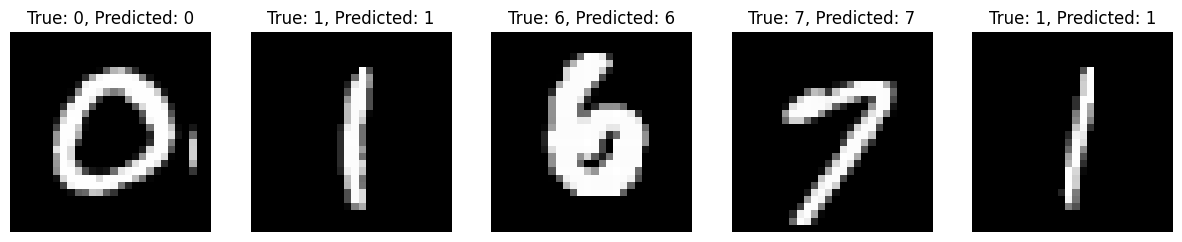

In [19]:
# Випадкові зображення з тестової вибірки
indices = np.random.randint(0, len(x_test), 5)
images = x_test[indices]
labels = y_test[indices]

# Прогнози для випадкових зображень
predictions = np.argmax(neural_net(images), axis=1)

# Візуалізація зображень та їх відповідних прогнозів
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    axes[i].imshow(image.reshape(28, 28), cmap="gray")
    axes[i].set_title(f"True: {label}, Predicted: {prediction}")

    if label != prediction:
        axes[i].set_title(f"True: {label}, Predicted: {prediction}", color='red')
    else:
        axes[i].set_title(f"True: {label}, Predicted: {prediction}")
    axes[i].axis('off')  # вимкнення осей

plt.show()


# Матриця плутанини (confusion matrix).  Візуалізує кількість помилково класифікованих зображень

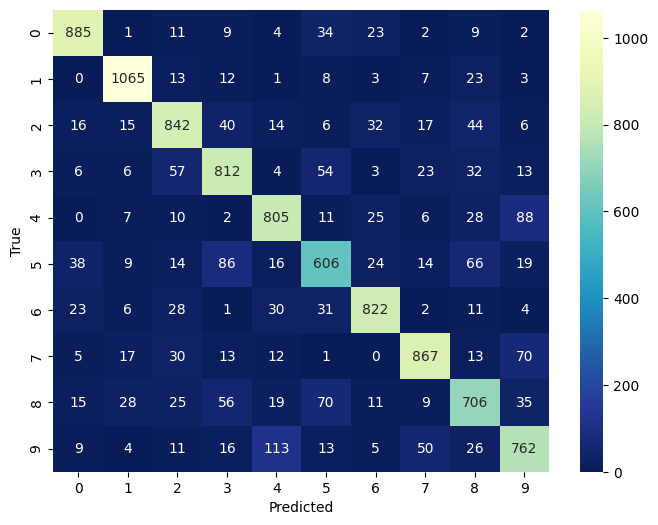

In [20]:
from sklearn.metrics import confusion_matrix

# Отримання прогнозів для всіх тестових зображень
test_predictions = np.argmax(neural_net(x_test), axis=1)

# Побудова матриці
conf_matrix = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, cmap="gray", fmt='g')
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu_r", fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Метрики якості

In [22]:
# Прогнози для всіх тестових зображень
test_predictions = np.argmax(neural_net(x_test), axis=1)

print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       980
           1       0.91      0.94      0.93      1135
           2       0.81      0.81      0.81      1032
           3       0.77      0.82      0.80      1010
           4       0.79      0.82      0.80       982
           5       0.76      0.70      0.73       892
           6       0.87      0.87      0.87       958
           7       0.87      0.83      0.85      1028
           8       0.75      0.73      0.74       974
           9       0.75      0.74      0.75      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



Середня точність моделі 82% і варіюється від 75% до 91%

Частка зразків з правильною класифікацією в середньому 82%. Найвища для "1" - 94%, найнижча для "5" - 70%

Показник support вказує, що кількість екземплярів приблизно однакові, тобто дані збалансовані.